In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import math
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
def createDataframes(file_name):
    first_sheet, second_sheet = "Spectres", "Containment"
    df_spectres = pd.read_excel(file_name, sheet_name=first_sheet)
    df_containment = pd.read_excel(file_name, sheet_name=second_sheet)
    df_containment = df_containment.loc[:, ['Влага', 'Клейковина', 'Зольность']]
    np_spectres = df_spectres.loc[:, [name for name in list(df_spectres.columns)[1:]]].to_numpy()
    np_spectres_log = -np.log10(np_spectres)
    print(np_spectres_log)
    df_spectres = pd.DataFrame(np_spectres_log, columns=[wave for wave in range(2400, 1390, -10)])
    return df_spectres, df_containment

def getTrainData(df_y_data, column_name):
    return df_y_data.loc[0:len(df_y_data):2, column_name], df_y_data.loc[1:len(df_y_data):2, column_name]

In [10]:
def plotMlr(actual_data, predicted_data, name):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111)
    axis_x = range(1, len(predicted_data)+1)
    print(predicted_data)
    ax.plot(axis_x, [point for point in predicted_data], color='red', label='Спрогнозированные данные')
    ax.plot(axis_x, [point for point in actual_data], color='blue', label='Актуальные данные')
    ax.scatter(axis_x, predicted_data, color='red')
    ax.scatter(axis_x, actual_data, color='blue')
    plt.legend(loc='upper left')
    plt.xticks([i for i in axis_x])
    plt.xlabel('Номер измерения')
    plt.ylabel('Концентрация исследуемого образца' + ' '+ name)
    plt.show()
    
def calcMlr(actual_data, predicted_data):
    root_mean_square_error = np.sqrt(mean_squared_error(actual_data, predicted_data))
    r2_correlation_value = r2_score(actual_data, predicted_data)
    print(actual_data, predicted_data)
    return root_mean_square_error, r2_correlation_value

def mlrFit(df_x_data, df_y_data):
    x_train, x_test = df_x_data.iloc[0:len(df_x_data):2, :], df_x_data.iloc[1:len(df_x_data):2, :]
    components_names = ['Влага', 'Клейковина', 'Зольность']
    for comp_name in components_names:
        multimodel = linear_model.LinearRegression()
        y_train, y_test = getTrainData(df_y_data, comp_name)
        multimodel.fit(x_train, y_train)
        y_predict = multimodel.predict(x_test)
        plotMlr(actual_data=y_test, predicted_data=y_predict, name=comp_name)
        rmse, r2_for_model = calcMlr(y_train, y_predict)
        print(f"MSE for {comp_name} {rmse}")
        print(f"Correlation coeff for {comp_name} {r2_for_model}")

In [11]:
def performScaling(df_x_data, df_y_data):
    x_train, x_test = df_x_data.iloc[0:len(df_x_data):2, :], df_x_data.iloc[1:len(df_x_data):2, :]
    std_scale = preprocessing.StandardScaler().fit(x_train)
    x_train_scaled, x_test_scaled = std_scale.transform(x_train), std_scale.transform(x_test)
    print(x_train_scaled)
    y_train_moisture, y_test_moisture = getTrainData(df_y_data, 'Влага')
    regr = linear_model.LinearRegression()
    regr.fit(x_train_scaled, y_train_moisture)
    y_pred_moisture = regr.predict(x_test_scaled)
    plotMlr(actual_data=y_test_moisture, predicted_data=y_pred_moisture, name='влаги')
    rmse_moisture, r2_moisture = calcMlr(y_test_moisture, y_pred_moisture)
    print("СКО для влаги \n", rmse_moisture)
    print("К-т корреляции для влаги: \n", r2_moisture)

[[0.37099838 0.37768234 0.38007229 ... 0.78701382 0.86518563 0.9625735 ]
 [0.31318505 0.31957383 0.32184596 ... 0.69637202 0.76802097 0.85667287]
 [0.36171046 0.36855623 0.37110044 ... 0.7780644  0.85604888 0.95428594]
 ...
 [0.38048928 0.38753404 0.39008559 ... 0.80134291 0.88074411 0.97922451]
 [0.37345434 0.38007229 0.38247547 ... 0.79263496 0.86966623 0.96497072]
 [0.39555793 0.40263395 0.40527605 ... 0.82073554 0.90031936 0.99913228]]
[11.82466365 12.38791085 12.30305957 12.09540759 11.98846558 11.24105111
 11.72882199]


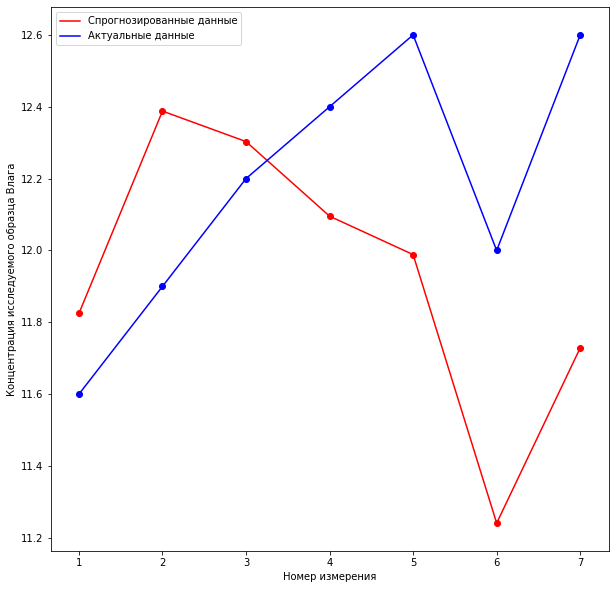

0     10.9
2     11.3
4     12.4
6     12.2
8     11.9
10    11.6
12    11.2
Name: Влага, dtype: float64 [11.82466365 12.38791085 12.30305957 12.09540759 11.98846558 11.24105111
 11.72882199]
MSE for Влага 0.5946443182400005
Correlation coeff for Влага -0.36214554996388704
[24.07803601 23.74710569 24.06591061 26.67236638 25.47872025 23.89289337
 26.93074832]


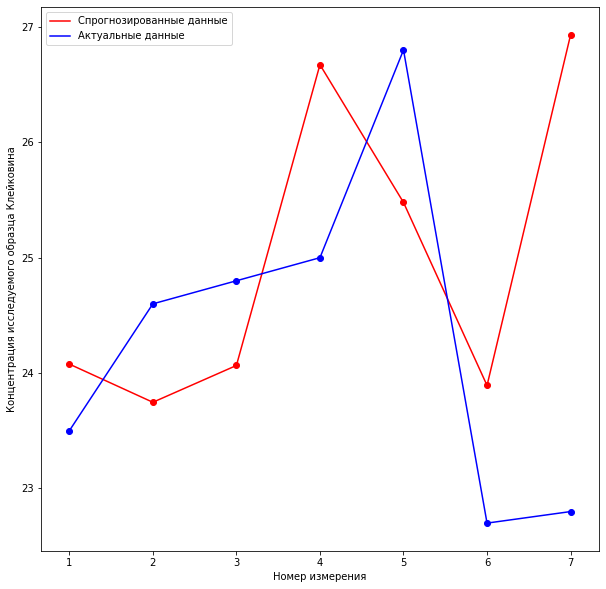

0     26.2
2     25.5
4     24.3
6     24.1
8     24.8
10    23.0
12    27.9
Name: Клейковина, dtype: float64 [24.07803601 23.74710569 24.06591061 26.67236638 25.47872025 23.89289337
 26.93074832]
MSE for Клейковина 1.5327195652587053
Correlation coeff for Клейковина -0.07140947524771968
[2.09336367 1.9412584  1.81510422 1.80736558 2.03005585 1.60127632
 1.29526561]


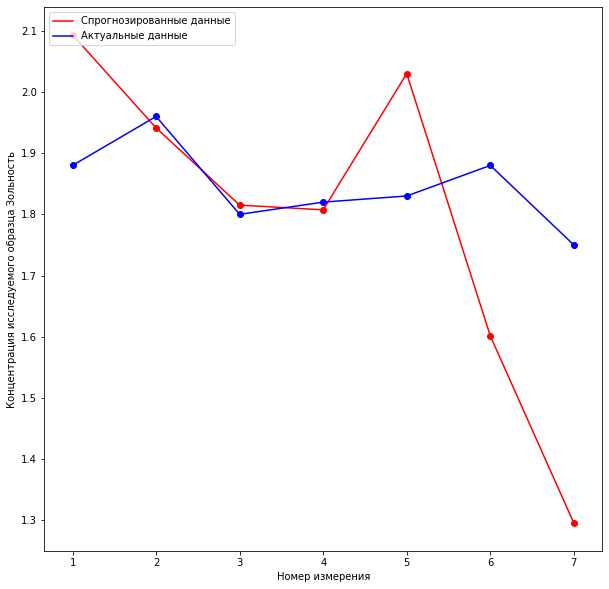

0     1.85
2     1.75
4     1.75
6     1.93
8     1.81
10    1.80
12    1.78
Name: Зольность, dtype: float64 [2.09336367 1.9412584  1.81510422 1.80736558 2.03005585 1.60127632
 1.29526561]
MSE for Зольность 0.2501332550745914
Correlation coeff for Зольность -17.0977899611353
[[ 1.1396813   1.13561364  1.13309881  1.13149433  1.12748219  1.12615049
   1.12859707  1.12932622  1.12673894  1.12568016  1.12843299  1.1377147
   1.14136309  1.14614592  1.14356479  1.14171355  1.14644812  1.14997484
   1.15427957  1.16177302  1.16100666  1.16000492  1.15577582  1.1522062
   1.14237912  1.13103225  1.12109244  1.11084864  1.10522197  1.10079282
   1.10079445  1.10197011  1.10502711  1.1117917   1.12434766  1.13169371
   1.13882781  1.14236022  1.14887208  1.15407374  1.16496981  1.17407763
   1.17959798  1.17775886  1.17323537  1.17283691  1.16922133  1.16698148
   1.16732181  1.16050525  1.14469896  1.12493986  1.10433479  1.08482041
   1.06932647  1.0600181   1.05429612  1.05557196  1.0584974

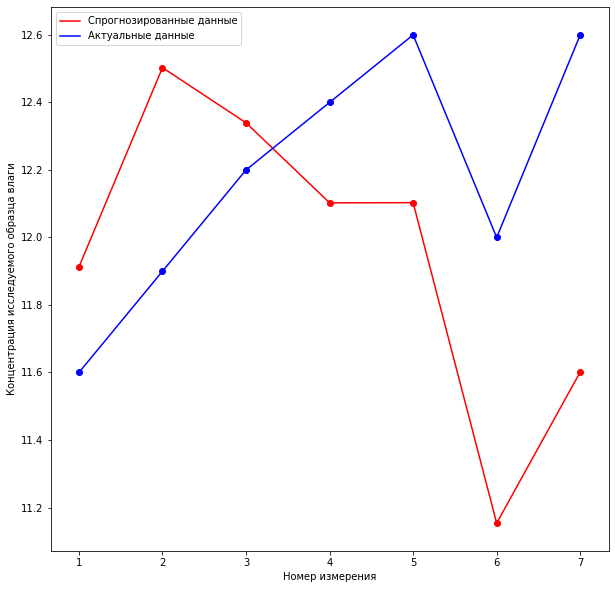

1     11.6
3     11.9
5     12.2
7     12.4
9     12.6
11    12.0
13    12.6
Name: Влага, dtype: float64 [11.91266352 12.50296669 12.33960322 12.10255717 12.10301949 11.15382721
 11.60144364]
СКО для влаги 
 0.6011181762789871
К-т корреляции для влаги: 
 -1.9807760994605723


In [12]:
def main():
    cwd = os.getcwd()
    cwd_wheat = "C:/Users/Alexander/Desktop/диплом"
    os.chdir(cwd_wheat)
    file_name_df = "Ставр_данные.xlsx"
    df_spectres, df_containment = createDataframes(file_name_df)
    mlrFit(df_x_data=df_spectres, df_y_data=df_containment)
    performScaling(df_x_data=df_spectres, df_y_data=df_containment)
    

if __name__ == "__main__":
    main()